In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Setup

In [20]:
!pip install torchgeometry

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchgeometry.losses import dice_loss
import torchvision
import torchvision.transforms.functional as TF

In [21]:
# The original paper set aside images which came from the following labs 
# as their test data. We follow their example.
testing_sites = ['OL', 'LL', 'C8', 'BH', 'AR', 'A7', 'A1']

# The dataset is loaded from google drive
rgbs_dir = '/content/drive/MyDrive/0_Public-data-Amgad2019_0.25MPP/rgbs_colorNormalized'
masks_dir = '/content/drive/MyDrive/0_Public-data-Amgad2019_0.25MPP/masks'

# Splitting training and testing data
training_names = []
test_names = []

# The rgbs and masks have the exact same filenames, so we do not need to treat
# them separately
for filename in os.listdir(rgbs_dir):
    # The lab location exists in the filename at the fifth and sixth characters.
    if filename[5:7] in testing_sites:
      test_names += [filename]
    else:
      training_names += [filename]

val_size = 22
train_size = 60

train_names, val_names = model_selection.train_test_split(training_names,
                                                          train_size = train_size,
                                                          test_size = val_size,
                                                          random_state = 7)

#### Model

In [22]:
model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)
device = torch.device("cuda:0")
model.to(device)

# There are two children in the DeepLab model, the encoder and the decoder. For
# finetuning, we freeze the encoder layers
#for i, child in enumerate(model.children()):
  #if i == 0:
    #for param in child.parameters():
      #param.requires_grad = False

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### Class Specification

In [23]:
# Class specification code written by Alex T.

def change_class_vals(mask):
   
  for i in range(1, 22):

    if i == 1 or i == 19 or i == 20:
      mask[mask == i] = 0
    elif i == 2:
      mask[mask == i] = 1
    elif i == 3 or i == 10 or i == 11 or i == 14:
      mask[mask == i] = 2
    elif i == 4:
      mask[mask == i] = 3
    else:
      mask[mask == i] = 4

  return mask


#### Loss and Optimizer

In [24]:
# Weights determined by auxiliary code written by Alex T.
weights = [0.4905573355962124, 0.695194226695798, 0.9165659564679096, 0.9391179214116163, 0.9585645598284636]

criterion = nn.CrossEntropyLoss(torch.FloatTensor(weights).to(device))
#criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                       threshold = 0.01, 
#                                                       patience = 3)

#### Data

In [25]:
# Means and stds determined by auxiliary code written by Alex T.
means = [0.7395, 0.5253, 0.7026]
stds = [0.1912, 0.2321, 0.1716]

class MakeDataset(Dataset):

  def __init__(self, filenames, training):

        self.training = training
        self.filenames = filenames

  def __len__(self):
      
      return len(self.filenames)

  # Basic data augmentation for training data
  def transform_train(self, rgb, mask):

        # Random crop
        i, j, h, w = torchvision.transforms.RandomCrop.get_params(
            rgb, output_size = (768, 768))
        rgb = TF.crop(rgb, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            rgb = TF.hflip(rgb)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            rgb = TF.vflip(rgb)
            mask = TF.vflip(mask)

        # Transform to tensor and normalize the rgb
        rgb = TF.to_tensor(rgb)
        rgb = TF.normalize(rgb, means, stds)

        mask = TF.to_tensor(mask)

        return rgb, mask
    
  def __getitem__(self, index):
      
        rgb_name = os.path.join(rgbs_dir, self.filenames[index])
        mask_name = os.path.join(masks_dir, self.filenames[index])
        
        rgb = Image.open(rgb_name)
        mask = Image.open(mask_name).convert('I;16')
        
        if self.training :

          rgb, mask = self.transform_train(rgb, mask)
          mask = change_class_vals(mask.squeeze(0)).long()

          return {'rgb': rgb, 'mask': mask}

        else :

          rgb = TF.to_tensor(TF.center_crop(rgb, output_size = (768, 768)))
          rgb = TF.normalize(rgb, means, stds)

          mask = TF.to_tensor(TF.center_crop(mask, output_size = (768, 768)))
          mask = change_class_vals(mask.squeeze(0)).long()

          return {'rgb': rgb, 'mask': mask}

train_data = MakeDataset(train_names, training = True)
val_data = MakeDataset(val_names, training = False)

batch_size = 2

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, 
                        shuffle = True, num_workers = 2)

#### Training

In [26]:
def pixel_acc(pred, truth):
  pred = torch.argmax(F.softmax(pred, dim=1), dim = 1).squeeze(1)
  acc = 0

  for i in range(len(pred)):
    acc += (pred[i] == truth[i]).sum() / torch.numel(pred[i])

  return acc

In [36]:
def train_model(model, criterion, optimizer, epochs):

  epochs = epochs

  validation_running_loss_history = []
  validation_pixel_acc_history = []

  for epoch in range(epochs):

    # We track the loss, the dice loss, and the pixelwise 
    # accuracy for each epoch
    train_loss_running = 0.0
    val_loss_running = 0.0
    train_dice_running = 0.0
    val_dice_running = 0.0
    train_pixel_running = 0.0
    val_pixel_running = 0.0

    model.train()
  
    for i, batch in enumerate(train_loader):
      x_train = batch['rgb'].to(device)
      y_train = batch['mask'].to(device)

      optimizer.zero_grad()
      y_pred = model(x_train)['out']

      # loss = 0.3 * dice_loss(y_pred, y_train) + 0.7 * criterion(y_pred, y_train)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()
      
      train_loss_running += loss.item() * len(y_pred)
      train_dice_running += dice_loss(y_pred, y_train) * len(y_pred)
      train_pixel_running += pixel_acc(y_pred, y_train)
      
    with torch.no_grad():
        
      model.eval()
        
      for ith_batch, sample_batched in enumerate(val_loader):
          x_val = sample_batched['rgb'].to('cuda')
          y_val = sample_batched['mask'].to('cuda')
            
          y_pred = model(x_val)['out']

          # val_loss = 0.3 * dice_loss(y_pred, y_val) + 0.7 * criterion(y_pred, y_val)
          val_loss = criterion(y_pred, y_val)
          val_loss_running += val_loss.item() * len(y_pred)
          val_dice_running += dice_loss(y_pred, y_val) * len(y_pred)
          val_pixel_running += pixel_acc(y_pred, y_val)

      print("================================================================================")
      print("Epoch {} completed".format(epoch + 1))
        
      train_loss = train_loss_running / train_size
      val_loss = val_loss_running / val_size
      train_dice_loss = train_dice_running / train_size
      val_dice_loss = val_dice_running / val_size
      train_pixel_acc = train_pixel_running / train_size
      val_pixel_acc = val_pixel_running / val_size
        
      print("Training loss: {}".format(train_loss))
      print("Training DICE loss: {}".format(train_dice_loss))
      print("Training Pixelwise Accuracy: {}".format(train_pixel_acc))
      print("Validation loss: {}".format(val_loss))
      print("Validation DICE loss: {}".format(val_dice_loss))
      print("Validation Pixelwise Accuracy: {}".format(val_pixel_acc))
      print("================================================================================")
      validation_running_loss_history.append(val_loss)
      validation_pixel_acc_history.append(val_pixel_acc)

    torch.cuda.empty_cache()
  
  return validation_running_loss_history, validation_pixel_acc_history

In [ ]:
results = train_model(model, criterion, optimizer, 40)

#### Evaluation

In [37]:
def pixel_class_acc(pred, truth, n):
  pred = torch.argmax(F.softmax(pred, dim=1), dim = 1).squeeze(1)
  acc = 0
  num_cases = len(pred)

  for i in range(len(pred)):
    class_size = torch.numel(truth[i][truth[i] == n])
    # If there are no pixels of the given class in a mask, we need to discount
    # that mask when we compute pixel accuracy 
    if class_size > 0 :
      matches = pred[i][pred[i] == truth[i]]
      acc += (matches == n).sum() / class_size
    else :
      num_cases -= 1

  return (acc, num_cases)

In [38]:
def evaluate(model):

  test_size = 69

  test_data = MakeDataset(test_names, training = False)
  test_loader = DataLoader(dataset = test_data, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

  with torch.no_grad():
        
    model.eval()
        
    test_dice_running = 0.0
    test_pixel_running = 0.0
    class_pixel_running = [0] * 5
    num_cases_per_class = [0] * 5

    for ith_batch, sample_batched in enumerate(test_loader):
        x_test = sample_batched['rgb'].to('cuda')
        y_test = sample_batched['mask'].to('cuda')
            
        y_pred = model(x_test)['out']

        test_dice_running += dice_loss(y_pred, y_test) * len(y_pred)
        test_pixel_running += pixel_acc(y_pred, y_test)
        for i in range(5) :
          acc, num_cases = pixel_class_acc(y_pred, y_test, i)
          class_pixel_running[i] += acc
          num_cases_per_class[i] += num_cases

  print("DICE Score: {}".format(1 - (test_dice_running / test_size)))
  print("Pixelwise Accuracy: {}".format(test_pixel_running / test_size))
  for i in range(5) :
    print("Pixelwise Accuracy for Class {}: {}".format(i, class_pixel_running[i] / 
                                                      num_cases_per_class[i]))

## Transfer Learning

For reference, let's view the model architecture once more.

In [39]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Let's also take a look at the model parameters.

In [40]:
for name, _ in model.named_parameters():
  print(name)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer1.1.conv3.weight
backbone.layer1.1.bn3.weight
backbone.layer1.1.bn3.bias
backbone.layer1.2.conv1.weight
backbone.layer1.2.bn1.weight
backbone.layer1.2.bn1.bias
backbone.layer1.2.conv2.weight
backbone.layer1.2.bn2.weight
backbone.layer1.2.bn2.bias
backbone.layer1.2.conv3.weight
backbone.layer1.2.bn3.weight
backbone.layer1.2.bn3.bias
backbone.layer2.0.conv1.weight
backbone.layer

We now perform transfer learning to see if we can improve our model's results with freezing and fine-tuning. More specifically, let's perform three distinct transfer learning methods:
1. Freeze every layer but the output Conv2d layer
2. Freeze the ASPP layer (partial freezing; performs fine-tuning on the remaining layers)
3. Selecting parameter freezing (SPF) -- Introduced in: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8671465&tag=1
  - Freeze the weights only
  - Freeze the biases only
  - Freeze a mixture of weights and biases

### Method 1: Freeze All But Output Layer

In [41]:
# Create a new instance of the model for output layer methodology
model_tf = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)

# Convert to CUDA
model_tf = model_tf.to(device)

# Freeze the every layer but the output layer
for name, param in model_tf.named_parameters():
  if 'classifier.4' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Create a new optimizer specialized for the output layer
optimizer_tf = torch.optim.Adam(model_tf.parameters(), lr = 0.0001)

In [42]:
results_tf = train_model(model_tf, criterion, optimizer_tf, 10)

Epoch 1 completed
Training loss: 1.4851357817649842
Training DICE loss: 0.7605553269386292
Training Pixelwise Accuracy: 0.36488771438598633
Validation loss: 1.5376773422414607
Validation DICE loss: 0.7791978120803833
Validation Pixelwise Accuracy: 0.3410181403160095
Epoch 2 completed
Training loss: 1.4668636043866476
Training DICE loss: 0.7441415190696716
Training Pixelwise Accuracy: 0.37872374057769775
Validation loss: 1.4832936200228604
Validation DICE loss: 0.7527554631233215
Validation Pixelwise Accuracy: 0.3635694086551666
Epoch 3 completed
Training loss: 1.4238329887390138
Training DICE loss: 0.7250507473945618
Training Pixelwise Accuracy: 0.4008219838142395
Validation loss: 1.4454789486798374
Validation DICE loss: 0.734420895576477
Validation Pixelwise Accuracy: 0.38181549310684204
Epoch 4 completed
Training loss: 1.39147336880366
Training DICE loss: 0.7095471620559692
Training Pixelwise Accuracy: 0.41426587104797363
Validation loss: 1.4424846714193171
Validation DICE loss: 0.72

In [43]:
evaluate(model_tf)

DICE Score: 0.39537346363067627
Pixelwise Accuracy: 0.3614855110645294
Pixelwise Accuracy for Class 0: 0.659808337688446
Pixelwise Accuracy for Class 1: 0.3761307895183563
Pixelwise Accuracy for Class 2: 2.4540833692299202e-05
Pixelwise Accuracy for Class 3: 0.0
Pixelwise Accuracy for Class 4: 0.0


### Method 2: Partial Freezing - Freeze ASPP Layer

In [44]:
# Create a new instance of the model for partial freezing methodology
model_tf_2 = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)

# Convert to CUDA
model_tf_2 = model_tf_2.to(device)

# Freeze the ASPP layer, which allows us to fine-tune the remaining layers
for name, param in model_tf_2.named_parameters():
  if 'classifier' in name and 'convs' not in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Create a new optimizer specialized for the layers to be fine-tuned
optimizer_tf_2 = torch.optim.Adam(model_tf_2.parameters(), lr = 0.0001)

In [45]:
results_tf_2 = train_model(model_tf_2, criterion, optimizer_tf_2, 10)

Epoch 1 completed
Training loss: 1.4424408753712972
Training DICE loss: 0.7392174005508423
Training Pixelwise Accuracy: 0.4383760094642639
Validation loss: 1.359052842313593
Validation DICE loss: 0.7269107699394226
Validation Pixelwise Accuracy: 0.5274550914764404
Epoch 2 completed
Training loss: 1.3404246687889099
Training DICE loss: 0.6916548013687134
Training Pixelwise Accuracy: 0.4857102632522583
Validation loss: 1.1520834998650984
Validation DICE loss: 0.6112545132637024
Validation Pixelwise Accuracy: 0.5803266763687134
Epoch 3 completed
Training loss: 1.2066456198692321
Training DICE loss: 0.6371040940284729
Training Pixelwise Accuracy: 0.5499295592308044
Validation loss: 1.1365650567141445
Validation DICE loss: 0.5782573223114014
Validation Pixelwise Accuracy: 0.5642502307891846
Epoch 4 completed
Training loss: 1.1198250512282053
Training DICE loss: 0.5907726883888245
Training Pixelwise Accuracy: 0.5820909738540649
Validation loss: 1.023289517922835
Validation DICE loss: 0.50514

In [46]:
evaluate(model_tf_2)

DICE Score: 0.6044864654541016
Pixelwise Accuracy: 0.5627650022506714
Pixelwise Accuracy for Class 0: 0.7267614603042603
Pixelwise Accuracy for Class 1: 0.4190879762172699
Pixelwise Accuracy for Class 2: 0.2801934778690338
Pixelwise Accuracy for Class 3: 0.24442905187606812
Pixelwise Accuracy for Class 4: 0.29298916459083557


### Method 3a: Freeze the Weights Only

In [47]:
# Create a new instance of the model for weight freezing methodology
model_tf_3a = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)

# Convert to CUDA
model_tf_3a = model_tf_3a.to(device)

# Freeze the weight parameter for every layer
for name, param in model_tf_3a.named_parameters():
  if 'classifier' in name and 'weight' not in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Create a new optimizer specialized for layer fine-tuning based on bias parameter
optimizer_tf_3a = torch.optim.Adam(model_tf_3a.parameters(), lr = 0.0001)

In [48]:
results_tf_3a = train_model(model_tf_3a, criterion, optimizer_tf_3a, 10)

Epoch 1 completed
Training loss: 1.6283112645149231
Training DICE loss: 0.7991068363189697
Training Pixelwise Accuracy: 0.19872847199440002
Validation loss: 1.615091930736195
Validation DICE loss: 0.8005816340446472
Validation Pixelwise Accuracy: 0.18531660735607147
Epoch 2 completed
Training loss: 1.6239950299263
Training DICE loss: 0.7987013459205627
Training Pixelwise Accuracy: 0.19661138951778412
Validation loss: 1.6445239999077537
Validation DICE loss: 0.8048081994056702
Validation Pixelwise Accuracy: 0.17157360911369324
Epoch 3 completed
Training loss: 1.620372442404429
Training DICE loss: 0.7978956699371338
Training Pixelwise Accuracy: 0.2007707804441452
Validation loss: 1.6381908871910789
Validation DICE loss: 0.8019555807113647
Validation Pixelwise Accuracy: 0.1924460232257843
Epoch 4 completed
Training loss: 1.6130264401435852
Training DICE loss: 0.7963734865188599
Training Pixelwise Accuracy: 0.21175886690616608
Validation loss: 1.641650384122675
Validation DICE loss: 0.8034

In [49]:
evaluate(model_tf_3a)

DICE Score: 0.3155532479286194
Pixelwise Accuracy: 0.15982355177402496
Pixelwise Accuracy for Class 0: 0.15583811700344086
Pixelwise Accuracy for Class 1: 0.20706920325756073
Pixelwise Accuracy for Class 2: 0.2806132435798645
Pixelwise Accuracy for Class 3: 0.07700987160205841
Pixelwise Accuracy for Class 4: 0.30897924304008484


### Method 3b: Freeze the Biases Only

In [50]:
# Create a new instance of the model for weight freezing methodology
model_tf_3b = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)

# Convert to CUDA
model_tf_3b = model_tf_3b.to(device)

# Freeze the weight parameter for every layer
for name, param in model_tf_3b.named_parameters():
  if 'classifier' in name and 'bias' not in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Create a new optimizer specialized for layer fine-tuning based on bias parameter
optimizer_tf_3b = torch.optim.Adam(model_tf_3b.parameters(), lr = 0.0001)

In [51]:
results_tf_3b = train_model(model_tf_3b, criterion, optimizer_tf_3b, 10)

Epoch 1 completed
Training loss: 1.4421681384245555
Training DICE loss: 0.722479522228241
Training Pixelwise Accuracy: 0.41727957129478455
Validation loss: 1.173280493779616
Validation DICE loss: 0.6197376847267151
Validation Pixelwise Accuracy: 0.6054973006248474
Epoch 2 completed
Training loss: 1.2067406634489695
Training DICE loss: 0.6139006018638611
Training Pixelwise Accuracy: 0.5517481565475464
Validation loss: 1.0707013661211187
Validation DICE loss: 0.5302819013595581
Validation Pixelwise Accuracy: 0.6491228938102722
Epoch 3 completed
Training loss: 1.1956578135490417
Training DICE loss: 0.602188229560852
Training Pixelwise Accuracy: 0.5714327096939087
Validation loss: 1.2757824063301086
Validation DICE loss: 0.5917925834655762
Validation Pixelwise Accuracy: 0.5742146968841553
Epoch 4 completed
Training loss: 1.0342493375142416
Training DICE loss: 0.5416943430900574
Training Pixelwise Accuracy: 0.6331444978713989
Validation loss: 0.984093801541762
Validation DICE loss: 0.453265

In [52]:
evaluate(model_tf_3b)

DICE Score: 0.6026940941810608
Pixelwise Accuracy: 0.5590761303901672
Pixelwise Accuracy for Class 0: 0.6426898241043091
Pixelwise Accuracy for Class 1: 0.46428394317626953
Pixelwise Accuracy for Class 2: 0.49535495042800903
Pixelwise Accuracy for Class 3: 0.5686829686164856
Pixelwise Accuracy for Class 4: 0.15939456224441528


### Method 3c: Freeze a Mixture of Weights and Biases

In [53]:
# Create a new instance of the model for weight/bias mixture freezing methodology
model_tf_3c = torchvision.models.segmentation.deeplabv3_resnet50(num_classes = 5)

# Convert to CUDA
model_tf_3c = model_tf_3c.to(device)

# Freeze the weight or bias parameter for various layers
for name, param in model_tf_3c.named_parameters():
  if 'classifier.0.convs' in name:
    if 'convs.0' in name and 'weight' in name:
      param.requires_grad = True
    elif 'convs.1' in name and 'bias' in name:
      param.requires_grad = True
    elif 'convs.2' in name and 'weight' in name:
      param.requires_grad = True
    elif 'convs.3' in name and 'bias' in name:
      param.requires_grad = True
    elif 'convs.4' in name and 'weight' in name:
      param.requires_grad = True
    elif 'project.0' in name:
      param.requires_grad = True
    elif 'project.1.bias' in name:
      param.requires_grad = True
    elif 'classifier.1' in name:
      param.requires_grad = True
    elif name == 'classifier.2.bias':
      param.requires_grad = True
    elif 'classifier.4' in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
    
# Create a new optimizer specialized for layer fine-tuning based on weight or bias parameter
optimizer_tf_3c = torch.optim.Adam(model_tf_3c.parameters(), lr = 0.0001)

In [54]:
results_tf_3c = train_model(model_tf_3c, criterion, optimizer_tf_3c, 10)

Epoch 1 completed
Training loss: 1.4891106963157654
Training DICE loss: 0.726887047290802
Training Pixelwise Accuracy: 0.3858219385147095
Validation loss: 1.305338447744196
Validation DICE loss: 0.5763529539108276
Validation Pixelwise Accuracy: 0.6147204637527466
Epoch 2 completed
Training loss: 1.2197648545106252
Training DICE loss: 0.604963481426239
Training Pixelwise Accuracy: 0.5899651646614075
Validation loss: 1.311362093145197
Validation DICE loss: 0.44924598932266235
Validation Pixelwise Accuracy: 0.6673687696456909
Epoch 3 completed
Training loss: 1.262563661734263
Training DICE loss: 0.5978661775588989
Training Pixelwise Accuracy: 0.541766881942749
Validation loss: 1.033878730102019
Validation DICE loss: 0.5070706605911255
Validation Pixelwise Accuracy: 0.665056049823761
Epoch 4 completed
Training loss: 1.129315318663915
Training DICE loss: 0.5620856881141663
Training Pixelwise Accuracy: 0.6193432807922363
Validation loss: 0.9394031763076782
Validation DICE loss: 0.47694757580

In [55]:
evaluate(model_tf_3c)

DICE Score: 0.6406766176223755
Pixelwise Accuracy: 0.598440408706665
Pixelwise Accuracy for Class 0: 0.7617753744125366
Pixelwise Accuracy for Class 1: 0.5945518016815186
Pixelwise Accuracy for Class 2: 0.32055145502090454
Pixelwise Accuracy for Class 3: 0.24331802129745483
Pixelwise Accuracy for Class 4: 0.16896791756153107


### Visualization of Results

Let's take a look at the validation losses and validation pixelwise accuracies for each transfer learning methodology we used.

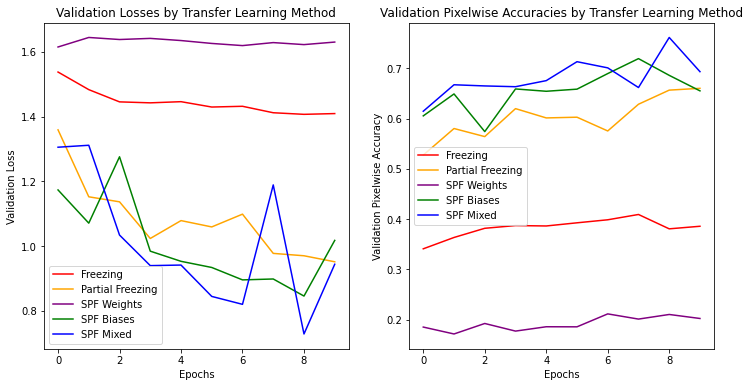

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(results_tf[0], label = 'Freezing', color = 'red')
ax[0].plot(results_tf_2[0], label = 'Partial Freezing', color = 'orange')
ax[0].plot(results_tf_3a[0], label = 'SPF Weights', color = 'purple')
ax[0].plot(results_tf_3b[0], label = 'SPF Biases', color = 'green')
ax[0].plot(results_tf_3c[0], label = 'SPF Mixed', color = 'blue')
ax[0].set_title("Validation Losses by Transfer Learning Method")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Validation Loss")
ax[0].legend()

acc_results = [results_tf[1], results_tf_2[1], results_tf_3a[1], results_tf_3b[1], results_tf_3c[1]] 

acc_vals_new = []
for i in range(5):
  accs = []
  for j in range(10):
    accs.append(acc_results[i][j].item())
  acc_vals_new.append(accs)

ax[1].plot(acc_vals_new[0], label = 'Freezing', color = 'red')
ax[1].plot(acc_vals_new[1], label = 'Partial Freezing', color = 'orange')
ax[1].plot(acc_vals_new[2], label = 'SPF Weights', color = 'purple')
ax[1].plot(acc_vals_new[3], label = 'SPF Biases', color = 'green')
ax[1].plot(acc_vals_new[4], label = 'SPF Mixed', color = 'blue')
ax[1].set_title("Validation Pixelwise Accuracies by Transfer Learning Method")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Validation Pixelwise Accuracy")
ax[1].legend()

plt.show()

Based on the results shown above, the partial freezing, SPF biases, and SPF mixed methodologies give the best results. These results are consistent with the findings in the parameter repurposing paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8671465&tag=1. 

Let's go with the SPF mixed methodology and see if we can obtain even better results. The best methodology might vary with reruns of this notebook, but this methodology is surely one of the more efficient ones. Let's now use this transfer learning methodology again, training for an additional 30 epochs for a total of 40 epochs; the goal is to see how much better the model can perform.

In [73]:
results_tf_3c_new = train_model(model_tf_3c, criterion, optimizer_tf_3c, 30)

Epoch 1 completed
Training loss: 1.0073896149794261
Training DICE loss: 0.5245549082756042
Training Pixelwise Accuracy: 0.6240836977958679
Validation loss: 0.8071953329173002
Validation DICE loss: 0.3943120837211609
Validation Pixelwise Accuracy: 0.7188830375671387
Epoch 2 completed
Training loss: 1.0318232417106628
Training DICE loss: 0.5167592763900757
Training Pixelwise Accuracy: 0.6265026330947876
Validation loss: 0.8234805369918997
Validation DICE loss: 0.40370050072669983
Validation Pixelwise Accuracy: 0.7066993713378906
Epoch 3 completed
Training loss: 0.998701008160909
Training DICE loss: 0.4959092438220978
Training Pixelwise Accuracy: 0.6592446565628052
Validation loss: 0.9408713213422082
Validation DICE loss: 0.33676019310951233
Validation Pixelwise Accuracy: 0.7377522587776184
Epoch 4 completed
Training loss: 0.9644244035085042
Training DICE loss: 0.4992170035839081
Training Pixelwise Accuracy: 0.6407400965690613
Validation loss: 0.9716810963370583
Validation DICE loss: 0.46

Now let's see how much better the model performs.

In [74]:
evaluate(model_tf_3c)

DICE Score: 0.6851816773414612
Pixelwise Accuracy: 0.6151418089866638
Pixelwise Accuracy for Class 0: 0.8701614737510681
Pixelwise Accuracy for Class 1: 0.38888296484947205
Pixelwise Accuracy for Class 2: 0.4856630563735962
Pixelwise Accuracy for Class 3: 0.4586469531059265
Pixelwise Accuracy for Class 4: 0.31635910272598267
